In [27]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import basedosdados as bd
import re
import json
import string
import plotly
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go

In [2]:
municipios = pd.read_csv("csv/municipios.csv")
zonas_eleitorais = pd.read_csv("csv/zona_eleitoral_2.csv", error_bad_lines=False, delimiter=',')

zonas_eleitorais = zonas_eleitorais[zonas_eleitorais['uf'].eq('RJ') & zonas_eleitorais['nome_municipio'].eq('RIO DE JANEIRO')]
zonas_eleitorais['id'].replace('(19-0*)','',regex=True, inplace = True)

zonas_eleitorais

,id,endereco_tse,cep,bairro,nome_municipio,uf,municipio_id,latitude,longitude
1724,1,"RUA SACADURA CABRAL, 226",20221161,SAUDE,RIO DE JANEIRO,RJ,3304557,-22.896590,-43.190357
1725,2,RUA SACADURA CABRAL 226 FUNDOS SOBRADO,20221161,SAUDE,RIO DE JANEIRO,RJ,3304557,-22.896590,-43.190357
1726,3,"RUA CONDE DE BAEPENDI, 40",22231140,LARANJEIRAS,RIO DE JANEIRO,RJ,3304557,-22.932839,-43.181064
1727,4,RUA JARDIM BOTÂNICO 1060,22460000,JARDIM BOTÂNICO,RIO DE JANEIRO,RJ,3304557,-22.964638,-43.219025
1728,5,RUA MIGUEL LEMOS 97 - TERREO,22071000,COPACABANA,RIO DE JANEIRO,RJ,3304557,-22.977268,-43.192752
...,...,...,...,...,...,...,...,...,...
1817,244,RUA DOM PEDRITO 1 - XVIII R.A.,23070170,CAMPO GRANDE,RIO DE JANEIRO,RJ,3304557,-22.903237,-43.572735
1818,245,ANTIGA ESTRADA RIO-SAO PAULO 176,23087005,CAMPO GRANDE,RIO DE JANEIRO,RJ,3304557,-22.890441,-43.565178
1819,246,RUA MARTINHO DE CAMPOS S/N POSTO AGRÍCOLA,23515040,SANTA CRUZ,RIO DE JANEIRO,RJ,3304557,-22.917710,-43.685579
1820,252,RUA MIGUEL LEMOS 97 3 ANDAR,22071000,COPACABANA,RIO DE JANEIRO,RJ,3304557,-22.977268,-43.192752


In [3]:
#dfFiliacaoPartidaria = pd.DataFrame(columns=['sigla_partido', 'zona', 'secao', 'nome_filiado', 'data_filiacao'])
#for i in list(string.ascii_uppercase):
queryFiliacaoPartidaria = """
    SELECT COUNT(*) AS n_filiados, FP.zona, FP.sigla_partido FROM `basedosdados.br_tse_filiacao_partidaria.filiacao_partidaria` AS FP
    WHERE FP.situacao_registro='regular' AND FP.id_municipio_tse={}
    GROUP BY FP.zona, FP.sigla_partido
    ORDER BY FP.zona""".format(municipios[municipios['nome_municipio'].eq('RIO DE JANEIRO')]['codigo_tse'].values[0])

dfFiliacaoPartidaria = bd.read_sql(queryFiliacaoPartidaria, billing_project_id='capacitacaoufrjanalytica')
    

Downloading: 100%|█████████████████████████████████████████████████████████████| 1564/1564 [00:01<00:00, 1314.43rows/s]


In [4]:
def returnBairro(zona):
    return zonas_eleitorais[zonas_eleitorais['id'].eq(str(zona))]['bairro'].values[0]

dfFiliacaoPartidaria['bairro'] = dfFiliacaoPartidaria['zona'].map(lambda x: returnBairro(x))

In [5]:
def returnLat(zona):
    return zonas_eleitorais[zonas_eleitorais['id'].eq(str(zona))]['latitude'].values[0] 
def returnLon(zona):
    return zonas_eleitorais[zonas_eleitorais['id'].eq(str(zona))]['longitude'].values[0] 

dfFiliacaoPartidaria['latitude'] = dfFiliacaoPartidaria['zona'].map(lambda x: returnLat(x))
dfFiliacaoPartidaria['longitude'] = dfFiliacaoPartidaria['zona'].map(lambda x: returnLon(x))

In [56]:

fig = px.scatter_mapbox(dfFiliacaoPartidaria,lat='latitude',lon='longitude',
                    size='n_filiados', color='sigla_partido')

fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=9, mapbox_center_lat = -22.85,
                  margin={"r":0,"t":0,"l":0,"b":0})

fig.show()



<AxesSubplot:ylabel='Frequency'>

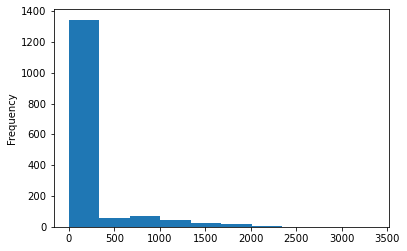

In [17]:
dfFiliacaoPartidaria['n_filiados'].plot.hist()